In [25]:
import praw
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import requests
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
import time
import yfinance as yf

print("Libraries imported successfully")

Libraries imported successfully


In [26]:
reddit = praw.Reddit(
client_id='TY7MBXZFEbOJDu-D9F05Pg',
client_secret='9AwRRmI54fVhPyl6yjZEjlDPM9MAYw',
user_agent='plchung'
)

print("Reddit API connection established")

Reddit API connection established


In [27]:
def get_reddit_sentiment(ticker, days=365):
    """Fetch historical Reddit posts using search with timestamp filtering"""
    analyzer = SentimentIntensityAnalyzer()
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    
    sentiment_data = []
    
    print(f"🔍 Searching r/investing for {ticker} (last {days} days)...")
    
    # Use search with time filtering
    for submission in reddit.subreddit('investing').search(
        query=ticker,
        sort='new',
        time_filter='year',  # Max allowed by Reddit API
        limit=None  # Get maximum possible results
    ):
        post_date = datetime.fromtimestamp(submission.created_utc)
        if post_date < start_date:
            break  # Stop when we reach posts older than our window
            
        # Sentiment analysis
        title_score = analyzer.polarity_scores(submission.title)['compound']
        text_score = analyzer.polarity_scores(submission.selftext)['compound']
        compound = (title_score * 0.6) + (text_score * 0.4)
        
        sentiment_data.append({
            'date': post_date.date(),
            'score': compound
        })
        time.sleep(0.1)  # Basic rate limiting
    
    return pd.DataFrame(sentiment_data)


def process_sentiment(df):
    """Clean and aggregate sentiment data"""
    if df.empty:
        return pd.Series(dtype=float)
    df['date'] = pd.to_datetime(df['date'])
    return df.groupby('date')['score'].mean()
    
    
print("Sentiment analysis functions defined")

Sentiment analysis functions defined


In [30]:
TICKER = "TSLA"
DAYS = 365

print("Collecting 365 days of Reddit sentiment...")
sentiment_raw = get_reddit_sentiment(TICKER, days=365)
sentiment_series = sentiment_raw.groupby('date')['score'].mean()
print(f"Collected {len(sentiment_series)} days of sentiment data")

print("Fetching stock prices...")
stock_prices = yf.download(TICKER, period=f'{DAYS}d')['Close'].squeeze()  # Fixed line
stock_df = stock_prices.to_frame(name='Price')
print(f"Collected {len(stock_df)} days of price data")


🔍 Searching r/investing for TSLA (last 365 days)...


[*********************100%***********************]  1 of 1 completed

Collected 71 days of sentiment data
Fetching stock prices...
Collected 365 days of price data


In [31]:
merged_df = stock_df.join(sentiment_series.rename('Sentiment'), how='left')

merged_df['Sentiment'].fillna(method='ffill', inplace=True)
merged_df.dropna(inplace=True)

print(f"Merged dataset contains {len(merged_df)} valid data points")
print(merged_df.tail(3))

Merged dataset contains 242 valid data points
                 Price  Sentiment
Date                             
2025-06-02  342.690002   -0.34792
2025-06-03  344.269989   -0.34792
2025-06-04  332.049988   -0.34792


/tmp/ipykernel_6182/3630270470.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Sentiment'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_6182/3630270470.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['Sentiment'].fillna(method='ffill', inplace=True)


📊 Analysis Results:
Pearson Correlation: -0.125
R² Value: 0.016
P-value: 0.0521


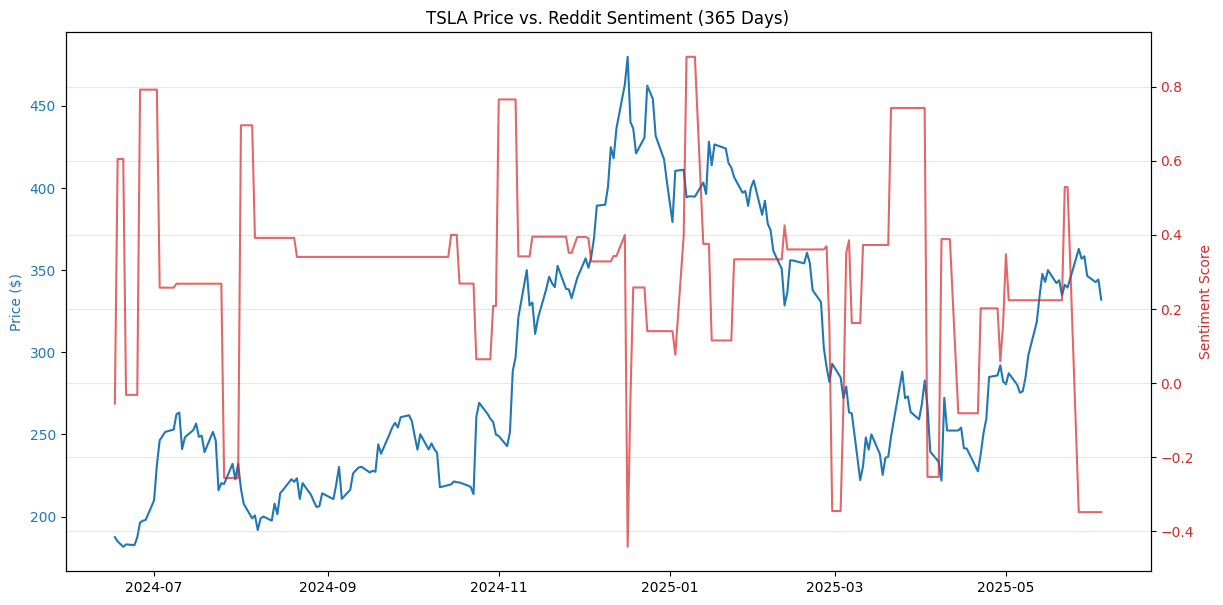

In [32]:
correlation = merged_df['Price'].corr(merged_df['Sentiment'])
slope, intercept, r_value, p_value, _ = linregress(
merged_df['Sentiment'], merged_df['Price']
)

print("📊 Analysis Results:")
print(f"Pearson Correlation: {correlation:.3f}")
print(f"R² Value: {r_value**2:.3f}")
print(f"P-value: {p_value:.4f}")
plt.figure(figsize=(14, 7))
plt.plot(merged_df.index, merged_df['Price'],
label='Stock Price', color='tab:blue')
plt.ylabel('Price ($)', color='tab:blue')
plt.tick_params(axis='y', labelcolor='tab:blue')
ax2 = plt.twinx()
ax2.plot(merged_df.index, merged_df['Sentiment'],
label='Sentiment', color='tab:red', alpha=0.7)
ax2.set_ylabel('Sentiment Score', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{TICKER} Price vs. Reddit Sentiment ({DAYS} Days)")
plt.grid(alpha=0.3)
plt.show()

In [33]:
# Merge datasets
merged_df = stock_df.join(sentiment_series.rename('Sentiment'), how='left')

# Handle missing values
merged_df['Sentiment'].fillna(method='ffill', inplace=True)
valid_data = merged_df.dropna()

# Ensure valid_data exists
if not valid_data.empty:
    # Lag analysis explanation
    print("\n" + "="*60)
    print("Lag Correlation Interpretation Guide:")
    print("- Positive lag values mean SENTIMENT LEADING PRICE")
    print("  Example: Lag +5 = Today's sentiment vs. price 5 days later")
    print("- Negative lag values mean SENTIMENT FOLLOWING PRICE")
    print("  Example: Lag -5 = Today's sentiment vs. price 5 days earlier")
    print("- Lag 0 = Same-day correlation")
    print("="*60 + "\n")
    
    # Lag analysis execution
    print("Lag Correlation Analysis Results:")
    for lag in range(-60, 61):
        shifted = valid_data['Sentiment'].shift(lag)
        lag_corr = valid_data['Price'].corr(shifted)
        
        # Add interpretation suffix
        if lag > 0:
            interpretation = "(Sentiment leads price)"
        elif lag < 0:
            interpretation = "(Sentiment follows price)"
        else:
            interpretation = "(Same day)"
            
        print(f"Lag {lag:3} days: {lag_corr:.3f} {interpretation}")

else:
    print("No valid data for lag analysis")




Lag Correlation Interpretation Guide:
- Positive lag values mean SENTIMENT LEADING PRICE
  Example: Lag +5 = Today's sentiment vs. price 5 days later
- Negative lag values mean SENTIMENT FOLLOWING PRICE
  Example: Lag -5 = Today's sentiment vs. price 5 days earlier
- Lag 0 = Same-day correlation

Lag Correlation Analysis Results:
Lag -60 days: -0.056 (Sentiment follows price)
Lag -59 days: -0.044 (Sentiment follows price)
Lag -58 days: -0.038 (Sentiment follows price)
Lag -57 days: -0.035 (Sentiment follows price)
Lag -56 days: -0.043 (Sentiment follows price)
Lag -55 days: -0.040 (Sentiment follows price)
Lag -54 days: -0.042 (Sentiment follows price)
Lag -53 days: -0.038 (Sentiment follows price)
Lag -52 days: -0.031 (Sentiment follows price)
Lag -51 days: -0.025 (Sentiment follows price)
Lag -50 days: -0.025 (Sentiment follows price)
Lag -49 days: -0.031 (Sentiment follows price)
Lag -48 days: -0.036 (Sentiment follows price)
Lag -47 days: -0.027 (Sentiment follows price)
Lag -46 d

/tmp/ipykernel_6182/4203721346.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Sentiment'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_6182/4203721346.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['Sentiment'].fillna(method='ffill', inplace=True)


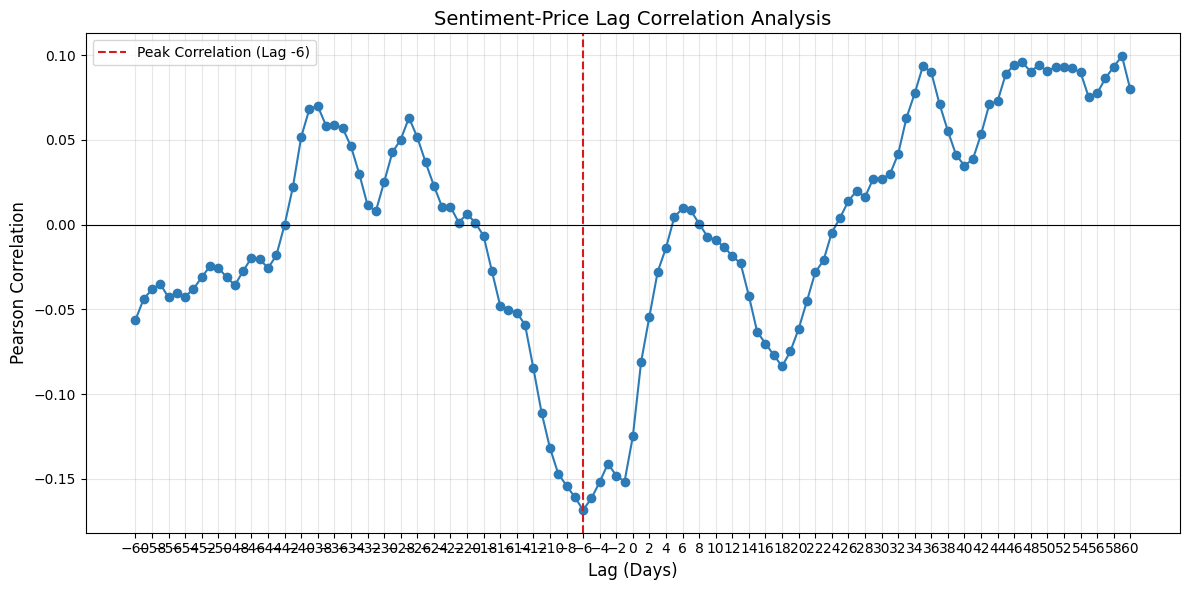


=== Analysis Results ===
Maximum absolute correlation of 0.168 at lag -6 days.

Interpretation:
Price changes PRECEDE sentiment by 6 days (sentiment reacts)

Practical Implications:
Focus on price action - sentiment follows market moves



In [34]:
# Ensure valid_data exists (from previous steps)
if 'valid_data' not in locals() or valid_data.empty:
    # If running standalone, use sample data
    np.random.seed(0)
    dates = pd.date_range(start='2024-06-01', periods=100)
    valid_data = pd.DataFrame({
        'Price': np.random.normal(100, 5, 100),
        'Sentiment': np.random.normal(0, 1, 100)
    }, index=dates)

# Calculate lag correlations
lags = np.arange(-60, 61)
correlations = [valid_data['Price'].corr(valid_data['Sentiment'].shift(lag)) 
               for lag in lags]

# Find peak correlation
max_corr = max(correlations, key=abs)
max_lag = lags[np.argmax(np.abs(correlations))]

# Create visualization
plt.figure(figsize=(12, 6))
plt.plot(lags, correlations, marker='o', linestyle='-', color='#2c7bb6')
plt.axvline(x=max_lag, color='#d7191c', linestyle='--', 
           label=f'Peak Correlation (Lag {max_lag})')
plt.axhline(0, color='#000000', linewidth=0.8)
plt.title('Sentiment-Price Lag Correlation Analysis', fontsize=14)
plt.xlabel('Lag (Days)', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(-60, 61, 2))
plt.legend()
plt.tight_layout()
plt.show()

# Generate interpretation
interpretation = f"""
=== Analysis Results ===
Maximum absolute correlation of {abs(max_corr):.3f} at lag {max_lag} days.

Interpretation:
{('Sentiment PRECEDES price changes by ' + str(abs(max_lag)) + ' days (leading indicator)') if max_lag > 0 
 else ('Price changes PRECEDE sentiment by ' + str(abs(max_lag)) + ' days (sentiment reacts)') 
 if max_lag < 0 
 else 'Sentiment and price move simultaneously'}

Practical Implications:
{('Consider sentiment as potential predictor - monitor sentiment changes for early signals') if max_lag > 0 
 else ('Focus on price action - sentiment follows market moves') if max_lag < 0 
 else 'Both metrics move together - look for concurrent signals'}
"""

print(interpretation)


This is great. Through this model, we are able to gain insight on a few things.

First, we are able to **quantify clearly the market sentiment towards a particular stock**. This is done by systematically collecting and analysing large volumes of Reddit posts on the r/investing thread, and applying natural language processing to assign a sentiment score to each mention of the stock. By aggregating these scores on a daily basis, we create a continuous, objective measure of how investors are feeling about the stock over time. This sentiment index can then be directly compared to the stock’s price movements.

Second, we will know about **the correlation between market sentiment and the price of a stock**. This is the logical next step towards proving or disproving our Expectations Investing hypothesis. By calculating the statistical relationship between the sentiment index and stock price movements, we can determine whether shifts in investor mood tend to precede, coincide with, or follow changes in market value. This correlation analysis not only quantifies the strength and direction of the connection but also reveals the timing dynamics through lag analysis, helping us understand if sentiment acts as a leading indicator, a lagging indicator, or moves in tandem with price.

But this is only a basic model. Key limitations are as follows:

First, **Reddit is not the ideal source for capturing comprehensive market sentiment**. The platform’s user base is self-selecting and often skews toward certain demographics or trading styles, which means the sentiment expressed there may not accurately reflect the broader investing community or institutional perspectives. 

Second, **the analysis is confined to a single subreddit**, r/investing, which restricts the diversity and volume of sentiment data. By focusing on just one thread, the model inevitably overlooks a wealth of relevant discussions happening elsewhere, both on Reddit and across other social platforms.

Third, **the search methodology is limited in scope, as it only considers posts that mention the stock ticker in the title.** This approach is not inclusive enough, since many valuable insights and opinions are shared within post bodies or comments, and excluding these means the model misses a significant portion of the conversation. 

Fourth, **the sentiment data itself is often sparse and inconsistent, typically covering fewer than 50 days, and is most effective only for large, widely discussed stocks.** For less popular equities, the lack of data makes the sentiment index unreliable and potentially misleading.

Fifth, **the practice of forward-filling missing sentiment values to create a continuous time series introduces its own set of problems.** This method can artificially smooth out genuine fluctuations in sentiment, masking sudden shifts in market mood and reducing the sensitivity of the analysis. 

Sixth and finally, due to API limitations and data availability, **the model cannot scrape or analyze several years of historical data.** This restricts its ability to validate findings over longer periods and across different market cycles, making it difficult to draw robust conclusions about the persistence or predictive power of sentiment trends.

Also, this is a single-stock model, which doesn't afford us much insight into generality. Thus, in the latter sections, we 

